In [1]:
# Import libraries
import re
import string

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from textblob import TextBlob
from imblearn.under_sampling import RandomUnderSampler
from langdetect import detect, DetectorFactory, LangDetectException

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.naive_bayes import ComplementNB

In [2]:
# Load dataset

data = pd.read_csv(r"...\music_album_reviews.csv")

data.head()

,Review,Rating
0,i think i actually under-rate ok computer if a...,5.0
1,i get why radiohead rub a lot of people the wr...,5.0
2,i would like to think i am good about not lett...,4.5
3,there are radiohead devotees like there were o...,4.0
4,i wrote a shining excellent review for this al...,5.0


In [3]:
data.shape

(80271, 2)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80271 entries, 0 to 80270
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Review  80245 non-null  object 
 1   Rating  78187 non-null  float64
dtypes: float64(1), object(1)
memory usage: 1.2+ MB


In [5]:
data.describe()

,Rating
count,78187.000000
mean,4.253258
std,0.871009
min,0.500000
25%,4.000000
50%,4.500000
75%,5.000000
max,5.000000


In [6]:
# Check unique values
data.nunique()

Review    79921
Rating       10
dtype: int64

In [7]:
# Check for null values
data.isnull().any()

Review    True
Rating    True
dtype: bool

In [8]:
data.isnull().sum()

Review      26
Rating    2084
dtype: int64

In [9]:
# Check for duplicated values.
data.duplicated().any()

True

In [10]:
data.duplicated().sum()

237

In [11]:
# Handle missing values - use average rating for Ratings, remove null reviews
data['Rating'].fillna(data['Rating'].mean(), inplace = True)

In [12]:
data.dropna(subset=['Review'], inplace=True)

In [13]:
# Handle duplicated data
data.drop_duplicates(inplace=True)

In [14]:
data.shape

(80027, 2)

[nltk_data] Downloading package stopwords to C:\Users\Njula
[nltk_data]     Chakaya\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


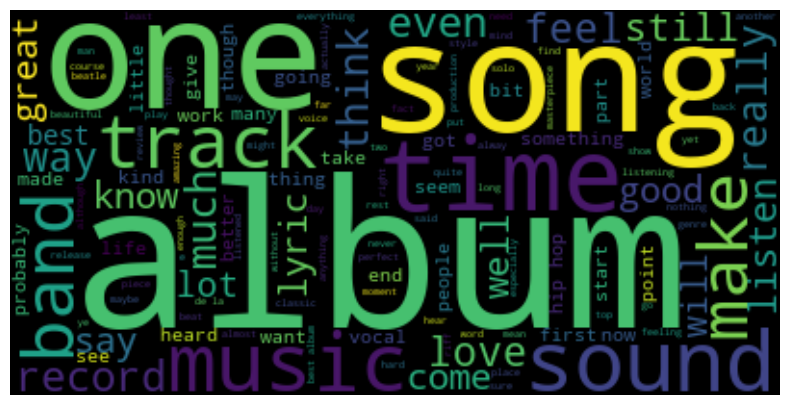

In [15]:
# Data Analysis using visuals

# Download and load the standard stop words from NLTK
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Combine all reviews into one large text
text = " ".join(Review for Review in data.Review)

# Generate a word cloud image
wordcloud = WordCloud(background_color="black").generate(text)

# Display the word cloud image:
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")  
plt.show()

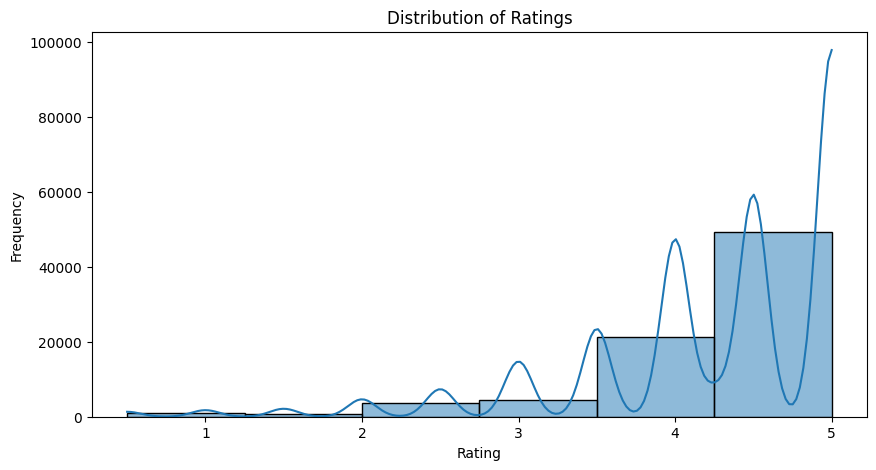

In [16]:
# Create a histogram of the ratings
plt.figure(figsize=(10, 5))
sns.histplot(data['Rating'], bins=6, kde=True)  
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()

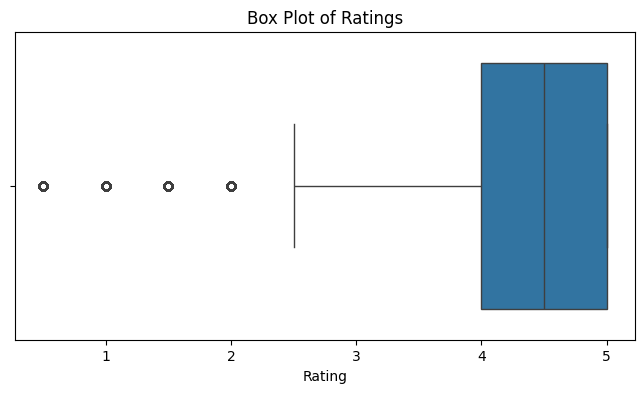

In [17]:
# Create a box plot of the ratings
plt.figure(figsize=(8, 4))
sns.boxplot(x=data['Rating'])
plt.title('Box Plot of Ratings')
plt.xlabel('Rating')
plt.show()

In [18]:
# Sentiment Analysis

# Step 1: Convert the data into a binary problem, assume ratings greater than 3 are good ratings and below 3 are bad ratings
threshold = 3.0
data['Label'] = np.where(data['Rating'] >= threshold, 1, 0)



,Review,Rating,Label
0,i think i actually under-rate ok computer if a...,5.0,1
1,i get why radiohead rub a lot of people the wr...,5.0,1
2,i would like to think i am good about not lett...,4.5,1
3,there are radiohead devotees like there were o...,4.0,1
4,i wrote a shining excellent review for this al...,5.0,1


In [19]:
# Only include reviews in English
DetectorFactory.seed = 0

def detect_language(text):
    try:
        return detect(text)
    except LangDetectException:
        return None
    
# Apply the language detection function
data['language'] = data['Review'].apply(detect_language)

# Filter the data to include only English reviews
english_data = data[data['language'] == 'en']

english_data.shape

(72343, 4)

In [20]:
# Step 2: Clean the text

def clean_text(text):
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text) # Removes text enclosed in brackets
    text = re.sub('https?://\S+|www\.\S+', '', text) # Removes URLs from the text
    text = re.sub('<.*?>+', '', text) # Removes text enclosed in <>
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text) # Removes all punctuation marks from the text
    text = re.sub('\n', '', text) # Removes newline characters from the text
    text = re.sub('\w*\d\w*', '', text) # Removes words with numbers

    return text

In [21]:
# Step 3: Remove stop words and lemmatize characters

nltk.download('wordnet')
def preprocess_text(text):
    stop_words = set(stopwords.words('english'))
    text = ' '.join(word for word in text.split() if word not in stop_words)

    lemma = WordNetLemmatizer()
    text = ' '.join(lemma.lemmatize(word) for word in text.split())

    text = ' '.join(word for word in text.split() if len(word) > 2)
    return text
    

[nltk_data] Downloading package wordnet to C:\Users\Njula
[nltk_data]     Chakaya\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [22]:
# Step 4: Apply preprocessing steps
english_data['clean_text'] = english_data['Review'].apply(clean_text)
english_data['final_text'] = english_data['clean_text'].apply(preprocess_text)

C:\Users\Njula Chakaya\AppData\Local\Temp\ipykernel_24572\1530897862.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  english_data['clean_text'] = english_data['Review'].apply(clean_text)
C:\Users\Njula Chakaya\AppData\Local\Temp\ipykernel_24572\1530897862.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  english_data['final_text'] = english_data['clean_text'].apply(preprocess_text)


In [23]:
english_data.head()

,Review,Rating,Label,language,clean_text,final_text
0,i think i actually under-rate ok computer if a...,5.0,1,en,i think i actually underrate ok computer if an...,think actually underrate computer anything bon...
1,i get why radiohead rub a lot of people the wr...,5.0,1,en,i get why radiohead rub a lot of people the wr...,get radiohead rub lot people wrong way lot peo...
2,i would like to think i am good about not lett...,4.5,1,en,i would like to think i am good about not lett...,would like think good letting wider critical w...
3,there are radiohead devotees like there were o...,4.0,1,en,there are radiohead devotees like there were o...,radiohead devotee like bowie devotee find unex...
4,i wrote a shining excellent review for this al...,5.0,1,en,i wrote a shining excellent review for this al...,wrote shining excellent review album browser w...


In [24]:
# Additional step getting the label using textblob (polarity)

# Function to derive sentiment using TextBlob
def get_textblob_sentiment(text):
    # Creating a TextBlob object
    testimonial = TextBlob(text)
    # Using polarity to determine sentiment (threshold: > 0 for positive, <= 0 for negative)
    return 1 if testimonial.sentiment.polarity > 0 else 0

# Apply the function to the cleaned and preprocessed text
english_data['tb_sentiment'] = english_data['final_text'].apply(get_textblob_sentiment)



C:\Users\Njula Chakaya\AppData\Local\Temp\ipykernel_24572\4167068710.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  english_data['tb_sentiment'] = english_data['final_text'].apply(get_textblob_sentiment)


In [25]:
# Step 5: Train the model
def get_models():
    models = []
    models.append(('Naive Bayes', ComplementNB()))
    return models

# Function conducts cross-validation using cross_val_score for different label sources and creates evaluation matrices
def train_and_evaluate(X_train, X_test, y_train, y_test, models, label_source):
    trained_models = {}
    results = []
    names = []
    kf = KFold(n_splits=10, random_state=42, shuffle=True)

    for name, model in models:
        cv_results = cross_val_score(model, X_train, y_train, cv=kf, scoring='accuracy')
        results.append(cv_results)
        names.append(name)
        print(f"{name} ({label_source}) - CV Mean Accuracy: {np.mean(cv_results):.4f}, Std: {np.std(cv_results):.4f}")

        # Final evaluation on the test set
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
        print(f"Classification Report for {name} ({label_source}):")
        print(classification_report(y_test, predictions))
        print("Confusion Matrix:")
        print(confusion_matrix(y_test, predictions))
        
        # Store the trained model
        trained_models[name] = model

    return trained_models

# TF-IDF technique to convert the 'text' column into a numerical representation
tfidf = TfidfVectorizer(lowercase=False)

X = tfidf.fit_transform(english_data['final_text'])
y = english_data['Label'].values
y_tb = english_data['tb_sentiment'].values

# Create the RandomUnderSampler object to balance the dataset for labels from ratings (undersample the 1)
rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(X, y)

# Train models using labels derived from ratings
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Train models using labels derived from TextBlob sentiment analysis
X_resampled_tb, y_resampled_tb = rus.fit_resample(X, y_tb)
X_train_tb, X_test_tb, y_train_tb, y_test_tb = train_test_split(X_resampled_tb, y_resampled_tb, test_size=0.2, random_state=42)

In [26]:
# Step 6: Run the models
print("Training and evaluation with labels from rating threshold:")
trained_models_rating = train_and_evaluate(X_train, X_test, y_train, y_test, get_models(), 'Rating Threshold')

print("Training and evaluation with labels from TextBlob sentiment analysis:")
trained_models_textblob = train_and_evaluate(X_train_tb, X_test_tb, y_train_tb, y_test_tb, get_models(), 'TextBlob Sentiment')

Training and evaluation with labels from rating threshold:
Naive Bayes (Rating Threshold) - CV Mean Accuracy: 0.5910, Std: 0.0208
Classification Report for Naive Bayes (Rating Threshold):
              precision    recall  f1-score   support

           0       0.67      0.68      0.67       540
           1       0.60      0.76      0.67       520
           2       0.54      0.39      0.46       553

    accuracy                           0.61      1613
   macro avg       0.60      0.61      0.60      1613
weighted avg       0.60      0.61      0.60      1613

Confusion Matrix:
[[368  79  93]
 [ 37 393  90]
 [148 187 218]]
Training and evaluation with labels from TextBlob sentiment analysis:
Naive Bayes (TextBlob Sentiment) - CV Mean Accuracy: 0.4919, Std: 0.0183
Classification Report for Naive Bayes (TextBlob Sentiment):
              precision    recall  f1-score   support

           0       0.88      0.27      0.42       597
           1       0.46      0.95      0.62       596
 

In [27]:
# Step 7: Prediction 
def predict_sentiment(comment, model, tfidf):
    # Assume the comment is already cleaned and preprocessed
    comment_list = [comment]
    comment_vector = tfidf.transform(comment_list)
    comment_prediction = model.predict(comment_vector)[0]
    
    '''if comment_prediction == 1:
        print("Positive comment")
    else:
        print("Negative comment")
'''
    if comment_prediction == 1:
        print("Positive comment")
    elif comment_prediction == 0:
        print("Negative comment")
    else:
        print("Neutral comment")
        
best_model_rating = trained_models_rating['Naive Bayes']
best_model_textblob = trained_models_textblob['Naive Bayes']

# Example usage
clean_comment = clean_text("Burna Boy's new album is a powerhouse of Afrobeat rhythms and powerful lyrics, but some tracks lack originality and feel too familiar.")
preprocessed_comment = preprocess_text(clean_comment)

# Predict using the model trained on rating thresholds
print("Using Rating Threshold Model:")
predict_sentiment(preprocessed_comment, best_model_rating, tfidf)

# Predict using the model trained on TextBlob sentiment
print("Using TextBlob Sentiment Model:")
predict_sentiment(preprocessed_comment, best_model_textblob, tfidf)

Using Rating Threshold Model:
Positive comment
Using TextBlob Sentiment Model:
Positive comment


In [28]:
# Example usage
clean_comment = clean_text("This album is a letdown. The beats are tired and the lyrics are uninspired. Overall, it just sucks.")
preprocessed_comment = preprocess_text(clean_comment)

# Predict using the model trained on rating thresholds
print("Using Rating Threshold Model:")
predict_sentiment(preprocessed_comment, best_model_rating, tfidf)

# Predict using the model trained on TextBlob sentiment
print("Using TextBlob Sentiment Model:")
predict_sentiment(preprocessed_comment, best_model_textblob, tfidf)

Using Rating Threshold Model:
Negative comment
Using TextBlob Sentiment Model:
Negative comment


In [29]:
# Example usage
clean_comment = clean_text("This album is okay")
preprocessed_comment = preprocess_text(clean_comment)

# Predict using the model trained on rating thresholds
print("Using Rating Threshold Model:")
predict_sentiment(preprocessed_comment, best_model_rating, tfidf)

# Predict using the model trained on TextBlob sentiment
print("Using TextBlob Sentiment Model:")
predict_sentiment(preprocessed_comment, best_model_textblob, tfidf)

Using Rating Threshold Model:
Negative comment
Using TextBlob Sentiment Model:
Positive comment
